In [1]:
import pandas as pd
import numpy as np
import torch
import random
from datasets import Dataset,DatasetDict
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score,
                            f1_score,  
                            roc_auc_score,
                            average_precision_score,
                            precision_recall_fscore_support,
                            precision_recall_curve,
                            auc)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BitsAndBytesConfig
import evaluate
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.impute import KNNImputer
# from peft import LoraConfig,get_peft_model
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig
from trl import SFTTrainer
from transformers import AutoTokenizer, DataCollatorWithPadding
import functools
import os
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"


# Function to set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure PyTorch uses all available threads
torch.set_num_threads(torch.get_num_threads())

def data_pre_processing(df):
    timestamp_columns = [col for col in df.columns if "timestamp" in col]
    other_non_imp_column_to_remove = ["id", "general_relapse_class"]
    columns_with_all_nan = df.columns[df.isna().all(axis=0)].tolist()
    print("shape of the dataframe before dropping columns", df.shape)
    df.drop(timestamp_columns + other_non_imp_column_to_remove + columns_with_all_nan, axis=1, inplace=True)
    print("shape of the dataframe after dropping columns", df.shape)
    categorical = df.select_dtypes(include=['bool', 'object']).columns.tolist()
    numerical = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    print("Length of categorical and numerical columns:", len(categorical), len(numerical))
    imputer = KNNImputer(n_neighbors=5, weights='uniform')
    imputed_data = imputer.fit_transform(df[numerical])
    df_imputed_numerical = pd.DataFrame(imputed_data, columns=numerical, index=df.index)
    df[numerical] = df_imputed_numerical
    return pd.get_dummies(df, columns=categorical, drop_first=True)

# In[3]:

df = pd.read_csv("/home/ubuntu/Tabular_Machine_Learning_Using_LLM/Data/patient_features_early_stage.csv")
df.rename(columns={'relapse?': 'general_relapse_class'}, inplace=True)
y = df["general_relapse_class"].values
df_encoded = data_pre_processing(df)
X = df_encoded.values
df_encoded.head()

def row_to_sentence_full(row):
    sentence_parts = [
        f"A patient of age {row['age']} started chemotherapy at {row['chemotherapy@t1_start_time']} days",
        f"underwent radiotherapy for {row['radiotherapy@t1_duration_days']} days",
        f"and had surgery at {row['surgery@t1_time']} days",
        f"with a history of smoking {row['nb_cig_packs_year']} cigarette packs per year",
        f"and {row['nb_cigs_day']} cigarettes per day",
    ]
    family_history = []
    if row['family_lung_cancer']:
        family_history.append("lung cancer")
    if row['family_other_cancer']:
        family_history.append("other types of cancer")
    if family_history:
        sentence_parts.append(f"and a family history that includes: {', '.join(family_history)}")
    else:
        sentence_parts.append("and no family history of cancer")
    for col in row.index:
        if pd.api.types.is_numeric_dtype(row[col]) and not '@' in col and col not in ['age', 'Unnamed: 0']:
            sentence_parts.append(f"{col.replace('_', ' ')} of {row[col]}")
        elif pd.api.types.is_bool_dtype(row[col]) and row[col]:
            sentence_parts.append(f"and has a condition of {col.replace('@', ' at ').replace('_', ' ')}")
    sentence = ', '.join(sentence_parts) + '.'
    return sentence


texts = df_encoded.apply(row_to_sentence_full, axis=1).tolist()
labels = y.tolist()

data = {'text': texts,
        'labels':labels}
new_df = pd.DataFrame(data)

X = new_df["text"]
y = new_df["labels"]

relapse_df = new_df[new_df['labels'] == 1]
non_relapse_df = new_df[new_df['labels'] == 0]

# For relapse patients
relapse_train, relapse_test = train_test_split(relapse_df, test_size=100, random_state=42)
relapse_train, relapse_val = train_test_split(relapse_train, test_size=50, random_state=42)

# For non-relapse patients
non_relapse_train, non_relapse_test = train_test_split(non_relapse_df, test_size=100, random_state=42)
non_relapse_train, non_relapse_val = train_test_split(non_relapse_train, test_size=50, random_state=42)

train_df = pd.concat([relapse_train, non_relapse_train])
test_df = pd.concat([relapse_test, non_relapse_test])
val_df = pd.concat([relapse_val, non_relapse_val])

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)
ds = DatasetDict({'train': train_dataset, 'val': val_dataset,'test':test_dataset})



# model name
model_name = 'mistralai/Mistral-7B-v0.1'

# preprocess dataset with tokenizer
def tokenize_examples(examples, tokenizer):
    tokenized_inputs = tokenizer(examples['text'])
    tokenized_inputs['labels'] = examples['labels']
    return tokenized_inputs

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenized_ds = ds.map(functools.partial(tokenize_examples, tokenizer=tokenizer), batched=True)
tokenized_ds = tokenized_ds.with_format('torch')

# qunatization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# lora config
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)
# load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=2
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.config.pad_token_id = tokenizer.pad_token_id

def collate_fn(batch, tokenizer):
    dict_keys = ['input_ids', 'attention_mask', 'labels']
    d = {k: [dic[k] for dic in batch] for k in dict_keys}
    d['input_ids'] = torch.nn.utils.rnn.pad_sequence(
        d['input_ids'], batch_first=True, padding_value=tokenizer.pad_token_id
    )
    d['attention_mask'] = torch.nn.utils.rnn.pad_sequence(
        d['attention_mask'], batch_first=True, padding_value=0
    )
    d['labels'] = torch.stack(d['labels'])
    return d

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits[:, 0] > 0).astype(int)
    
    # Calculate basic metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    
    # Calculate probabilities for the positive class
    probabilities = torch.sigmoid(torch.tensor(logits[:, 0])).numpy()
    
    # Calculate AUC-ROC
    auc_roc = roc_auc_score(labels, probabilities)
    
    # Calculate AUC-PR
    precision_curve, recall_curve, _ = precision_recall_curve(labels, probabilities)
    auc_pr = auc(recall_curve, precision_curve)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr
    }

class CustomTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss()
        # No need to apply sigmoid or softmax as CrossEntropyLoss does that internally
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
        
#         # forward pass
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
        
#         # compute custom loss without pos_weight
#         loss = F.binary_cross_entropy_with_logits(logits, labels.to(torch.float32))
#         return (loss, outputs) if return_outputs else loss

# define training args
training_args = TrainingArguments(
    output_dir = 'binary_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    num_train_epochs = 10,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

# train
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_ds['train'],
    eval_dataset = tokenized_ds['val'],
    tokenizer = tokenizer,
    data_collator = functools.partial(collate_fn, tokenizer=tokenizer),
    compute_metrics = compute_metrics
  
)



/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
shape of the dataframe before dropping columns (1348, 76)
shape of the dataframe after dropping columns (1348, 70)
Length of categorical and numerical columns: 59 11


Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 18023.35 examples/s]
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]
Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-v0.1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging res

In [2]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc Roc,Auc Pr
1,No log,0.714693,0.500000,0.666667,0.500000,1.000000,0.313600,0.382910
2,1.141300,0.549850,0.500000,0.666667,0.500000,1.000000,0.210200,0.345546
3,1.141300,0.577631,0.500000,0.666667,0.500000,1.000000,0.230000,0.353702
4,0.838000,0.788785,0.500000,0.666667,0.500000,1.000000,0.327600,0.388781
5,0.838000,0.546947,0.500000,0.666667,0.500000,1.000000,0.214000,0.347886
6,0.749300,0.768200,0.500000,0.666667,0.500000,1.000000,0.175400,0.336143
7,0.749300,0.578103,0.500000,0.666667,0.500000,1.000000,0.222800,0.352847
8,0.634000,0.544635,0.500000,0.666667,0.500000,1.000000,0.157400,0.331967
9,0.634000,0.582722,0.500000,0.666667,0.500000,1.000000,0.169800,0.335327
10,0.592200,0.591352,0.500000,0.666667,0.500000,1.000000,0.166400,0.334359


Checkpoint destination directory binary_classification/checkpoint-262 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory binary_classification/checkpoint-524 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. Th

TrainOutput(global_step=2620, training_loss=0.7771885486049507, metrics={'train_runtime': 3667.9971, 'train_samples_per_second': 2.857, 'train_steps_per_second': 0.714, 'total_flos': 3.629925845316403e+16, 'train_loss': 0.7771885486049507, 'epoch': 10.0})

In [3]:
tokenized_ds['test']

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [4]:
logits, _, _ = trainer.predict(tokenized_ds['test'])

In [5]:
tokenized_ds['test']['labels']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [6]:
predictions = np.argmax(logits, axis=-1)
print("accuracy:", np.around(accuracy_score(tokenized_ds['test']['labels'], predictions), decimals = 3))
print("precision:", np.around(precision_score(tokenized_ds['test']['labels'], predictions),decimals=3))
print("recall:", np.around(recall_score(tokenized_ds['test']['labels'], predictions),decimals=3))
print("f1:", np.around(f1_score(tokenized_ds['test']['labels'], predictions),decimals=3))
print("auc_roc:", np.around(roc_auc_score(tokenized_ds['test']['labels'], torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()[:, 1]),decimals=3))
print("auc_pr:", np.around(average_precision_score(tokenized_ds['test']['labels'], torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()[:, 1]),decimals=3))

accuracy: 0.63
precision: 0.717
recall: 0.43
f1: 0.538
auc_roc: 0.693
auc_pr: 0.719


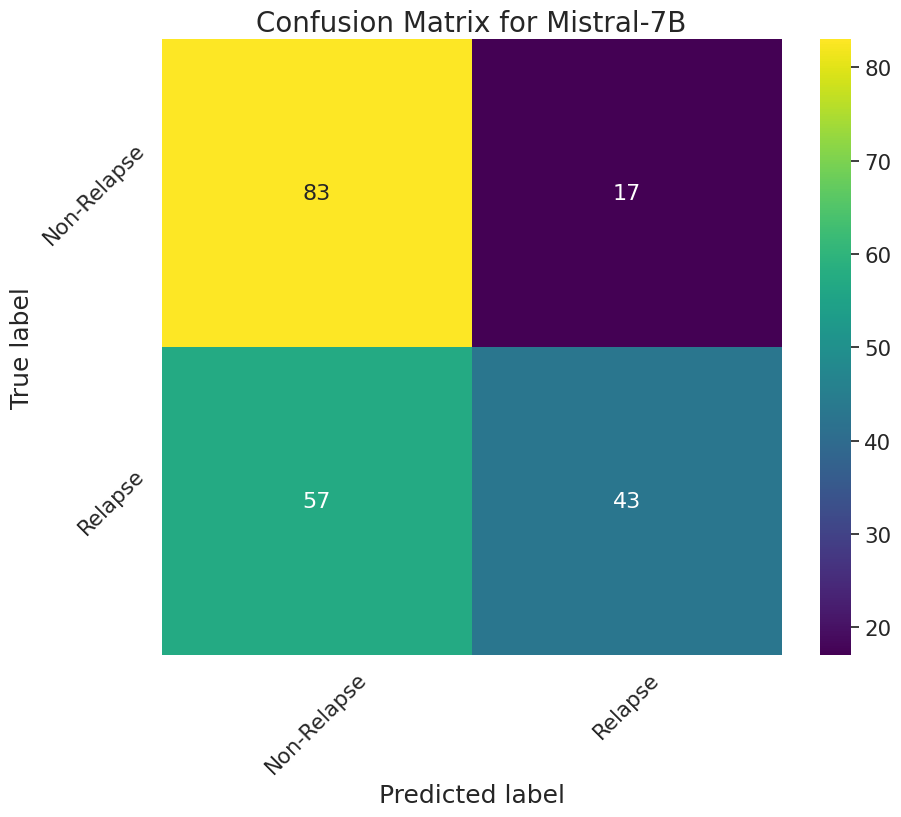

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(tokenized_ds['test']['labels'],  predictions)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)  # Increase font size
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=True, annot_kws={"size": 16},
            xticklabels=['Non-Relapse', 'Relapse'], yticklabels=['Non-Relapse', 'Relapse'])
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)
plt.title('Confusion Matrix for Mistral-7B', fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [9]:
plt.savefig('mistral_7b.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [40]:

data_ld = np.load('predict_prob_random_forest.npz')
y = data_ld["ground_truth"]
pred_prob_random_forest = data_ld["pred_prob"]
y_test = tokenized_ds['test']['labels']

In [41]:
pred_prob_random_forest

array([0.39206697, 0.69933546, 0.56852843, ..., 0.32428396, 0.21894212,
       0.29087241])

In [42]:
pred_prob_mistral_7b = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()[:, 1]

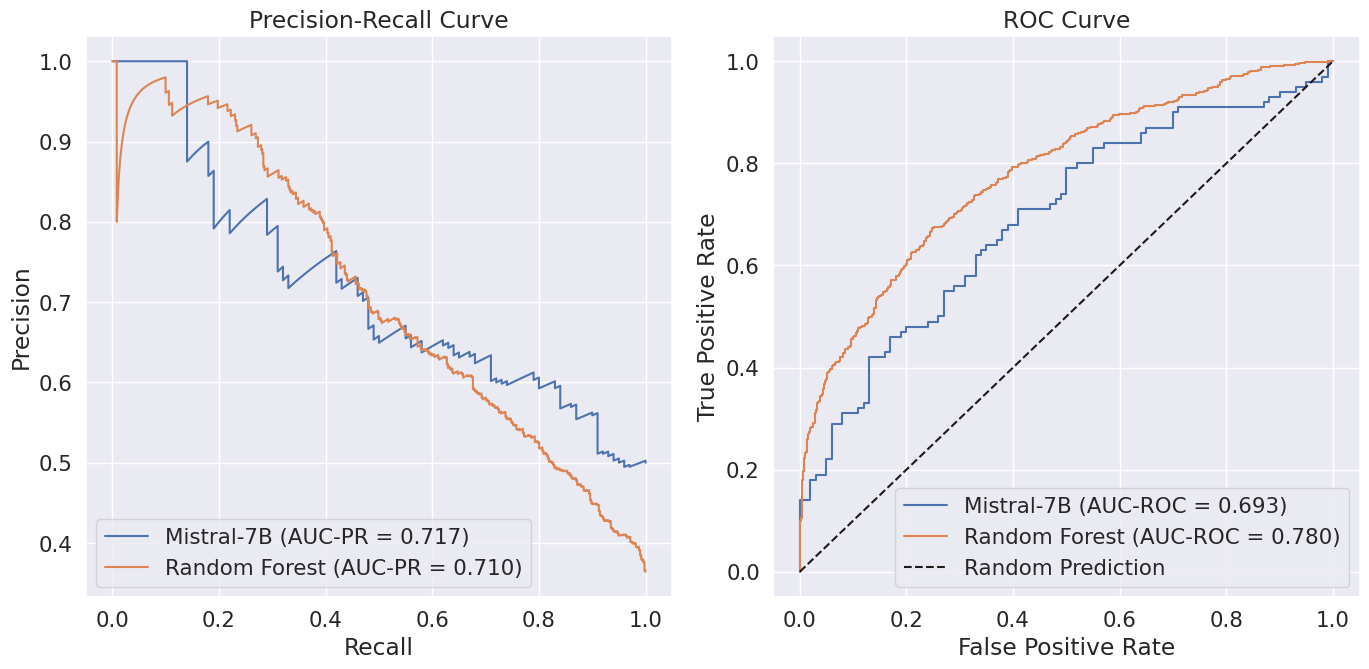

In [44]:
# Calculate the precision-recall curve points
from sklearn.metrics import precision_recall_curve, roc_curve, auc

precision_lr, recall_lr, _ = precision_recall_curve(y_test, pred_prob_mistral_7b)
precision_rf, recall_rf, _ = precision_recall_curve(y, pred_prob_random_forest)

# Calculate the AUC-PR
auc_pr_lr = auc(recall_lr, precision_lr)
auc_pr_rf = auc(recall_rf, precision_rf)

# Calculate the ROC curve points
fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_prob_mistral_7b)
fpr_rf, tpr_rf, _ = roc_curve(y, pred_prob_random_forest)

# Calculate the AUC-ROC
auc_roc_lr = auc(fpr_lr, tpr_lr)
auc_roc_rf = auc(fpr_rf, tpr_rf)

# Plotting both Precision-Recall and ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Precision-Recall Curve
ax1.plot(recall_lr, precision_lr, label=f'Mistral-7B (AUC-PR = {auc_pr_lr:.3f})')
ax1.plot(recall_rf, precision_rf, label=f'Random Forest (AUC-PR = {auc_pr_rf:.3f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()

# ROC Curve
ax2.plot(fpr_lr, tpr_lr, label=f'Mistral-7B (AUC-ROC = {auc_roc_lr:.3f})')
ax2.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC-ROC = {auc_roc_rf:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Prediction')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()

plt.tight_layout()
plt.savefig('precision_recall_roc_curves.png')
plt.show()